### 1. Introduction

# Dataset
### Diabetes : https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download
## Penjelasan Atribut Dataset
- Pregnancies               : Untuk menyatakan Jumlah kehamilan
- Glucose                   : Tingkat Glukosa dalam darah 2 jam dalam tes toleransi glukosa oral
- BMI                       : Indeks massa tubuh (berat badan dalam kg/(tinggi dalam m)^2)
- Age                       : Umur (tahun)
- DiabetesPedigreeFunction  : Presentase keturunan diabetes
- BloodPressure             : Tekanan darah diastolik (mm Hg)
- SkinThickness             : Ketebalan lipatan kulit pada triceps (mm)
- insulin                   : Tingkat insulin dalam darah 

- Outcome                   : Menyatakan hasil akhir 1 adalah Ya (terkena diabetes) dan 0 adalah Tidak (tidak terkena diabetes)


### 2. Data Undestanding

2.1 Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pymongo import MongoClient
from imblearn.over_sampling import SMOTE
import joblib

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

2.2 Read Dataset

In [2]:
diabetes_dataset = pd.read_csv('diabetes.csv')
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


2.3 Insert Dataset ke MongoDB

In [3]:
client = MongoClient("mongodb://localhost:27017/")
db = client["prediksi_diabetes"]             
collection = db["data_diabetes"]

2.4 convert t dictionary and insert to mongodb

In [4]:
data_dict = diabetes_dataset.to_dict("records")
collection.insert_many(data_dict)
print(f"Inserted {len(data_dict)} records into MongoDB.")

Inserted 768 records into MongoDB.


2.5 Load Dataset dari MongoDB

In [5]:
# Ambil kembali data dari MongoDB
data = pd.DataFrame(list(collection.find()))

# Drop kolom _id jika ada
if '_id' in data.columns:
    data.drop('_id', axis=1, inplace=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 3. Data Understanding

In [6]:
# Ukuran dataset
print("\n=== Ukuran Dataset ===")
print("Jumlah baris dan kolom:", diabetes_dataset.shape)

# Info tipe data
print("\n=== Info Dataset ===")
print(diabetes_dataset.info())

# Tipe data per kolom
print("\n=== Tipe Data per Kolom ===")
print(diabetes_dataset.dtypes)

# Cek missing values
print("\n=== Missing Values ===")
print(diabetes_dataset.isnull().sum())

# Cek duplikasi
print("\n=== Cek Duplikasi ===")
print("Jumlah duplikat:", diabetes_dataset.duplicated().sum())


=== Ukuran Dataset ===
Jumlah baris dan kolom: (768, 9)

=== Info Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

=== Tipe Data per Kolom ===
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness      

In [7]:
# Statistik deskriptif
print("\n=== Statistik Deskriptif ===")
print(diabetes_dataset.describe(include='all').to_string()) 


=== Statistik Deskriptif ===
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin         BMI  DiabetesPedigreeFunction         Age     Outcome
count   768.000000  768.000000     768.000000     768.000000  768.000000  768.000000                768.000000  768.000000  768.000000
mean      3.845052  120.894531      69.105469      20.536458   79.799479   31.992578                  0.471876   33.240885    0.348958
std       3.369578   31.972618      19.355807      15.952218  115.244002    7.884160                  0.331329   11.760232    0.476951
min       0.000000    0.000000       0.000000       0.000000    0.000000    0.000000                  0.078000   21.000000    0.000000
25%       1.000000   99.000000      62.000000       0.000000    0.000000   27.300000                  0.243750   24.000000    0.000000
50%       3.000000  117.000000      72.000000      23.000000   30.500000   32.000000                  0.372500   29.000000    0.000000
75%       6.000000  140.2

In [8]:
# Cek missing values
print("\n=== Missing Values ===")
print(diabetes_dataset.isnull().sum())


=== Missing Values ===
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [9]:
diabetes_dataset['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

## 4. Exploratory Data Analysis (EDA)

# 1. Analisis Univariate

Analisis univariat dilakukan untuk memahami distribusi masing-masing variabel secara individu.

<Figure size 1200x800 with 0 Axes>

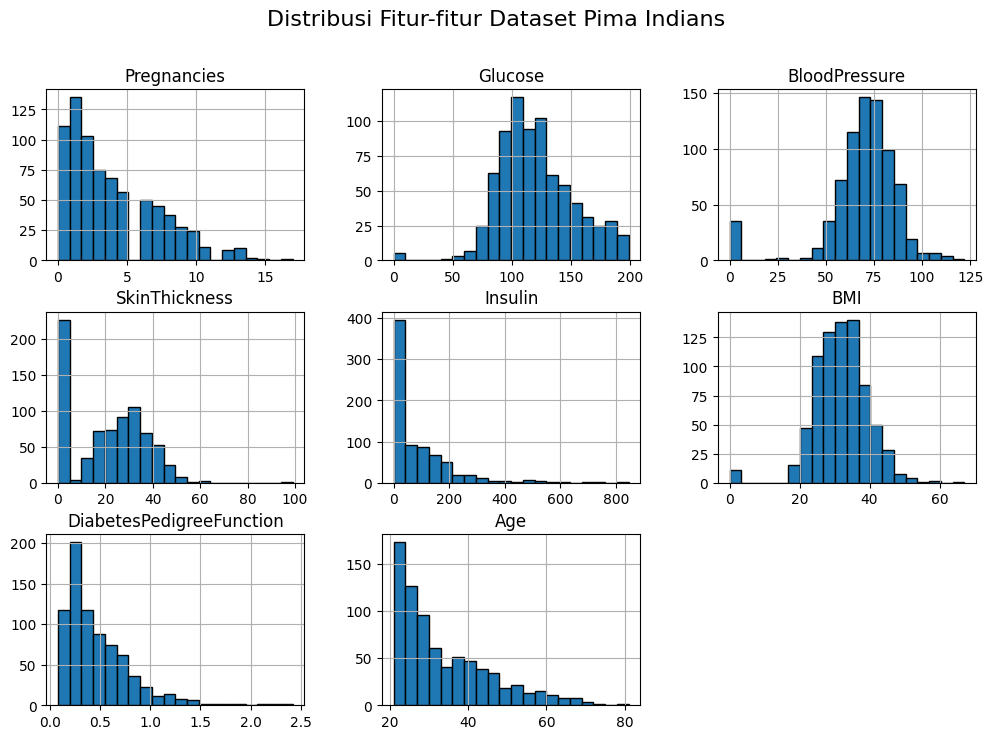

In [10]:
# 1. Visualisasi distribusi fitur numerik
plt.figure(figsize=(12, 8))
diabetes_dataset.drop('Outcome', axis=1).hist(bins=20, edgecolor='black', figsize=(12, 8))
plt.suptitle("Distribusi Fitur-fitur Dataset Pima Indians", fontsize=16)
plt.show()

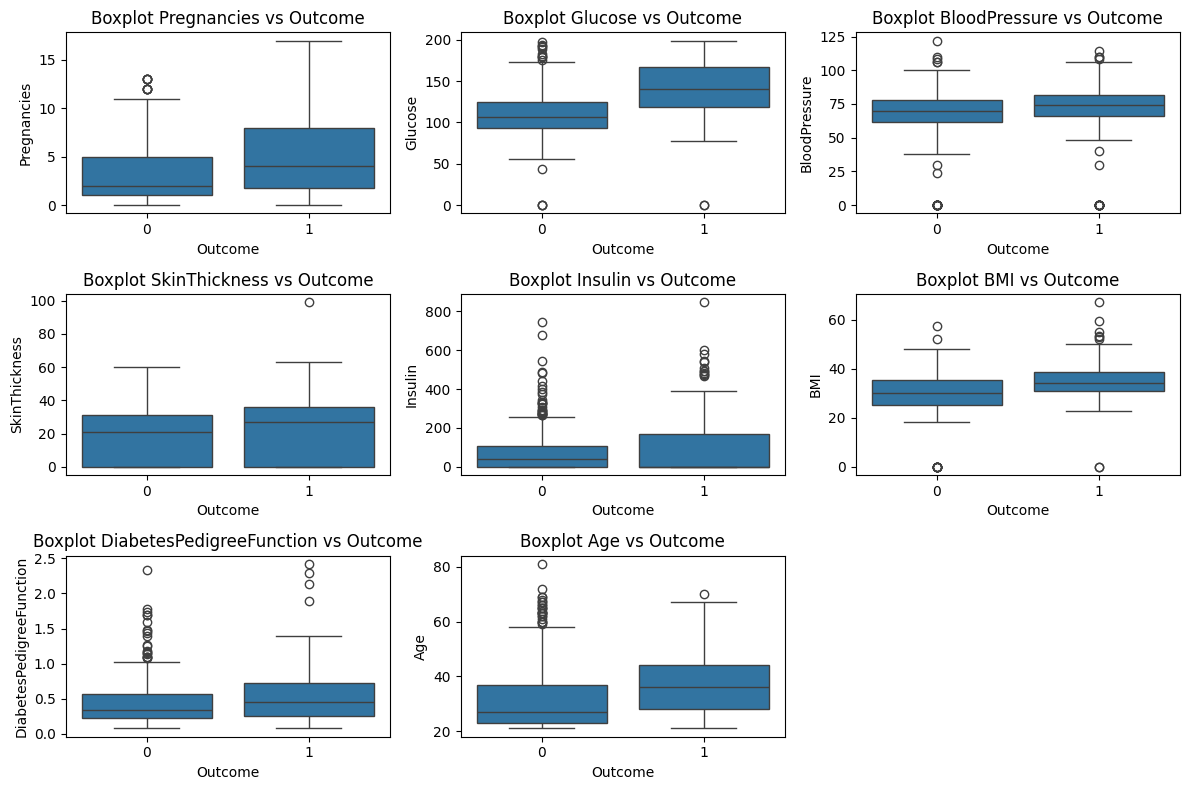

In [11]:
# 3. Boxplot untuk visualisasi pencilan
plt.figure(figsize=(12, 8))
for i, feature in enumerate(diabetes_dataset.drop('Outcome', axis=1).columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Outcome', y=feature, data=diabetes_dataset)
    plt.title(f'Boxplot {feature} vs Outcome')
plt.tight_layout()
plt.show()

C:\Users\Mega Global\AppData\Local\Temp\ipykernel_13776\984233593.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(x='Outcome', data=data, palette='Set2')


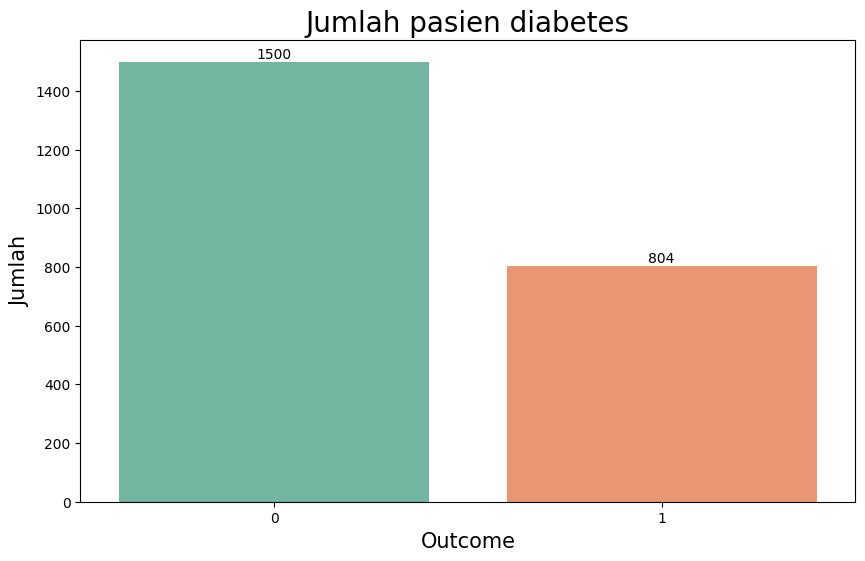

In [12]:
# Distribusi Variabel Target (Outcome)
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', data=data, palette='Set2')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien diabetes', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15)
plt.show()

Data yang disajikan menggambarkan bahwa terdapat 268 orang yang mengalami diabetes, sedangkan sebanyak 500 orang tidak mengalami kondisi diabetes.

# 2. Analisis Bivariate

Analisis bivariat dilakukan untuk melihat hubungan dua variabel, misalnya antara Outcome dan variabel lain.

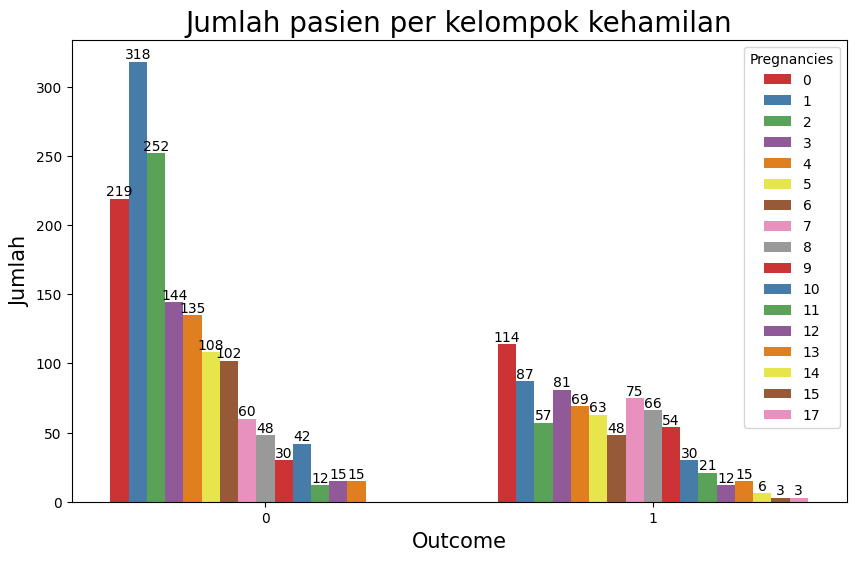

In [13]:
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', hue='Pregnancies', data=data, palette='Set1')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien per kelompok kehamilan', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15)
plt.show() 

Jumlah pasien perkelompok kehamilan yang paling banyak terkena diabets adalah 0 kehamilan dengan jumlah 38 orang lalu diikuti dengan 3 kehamilan dengan jumlah 27 orang dan yang paling sedikit adalah 17 kehamilan dengan jumlah 1 orang.

# 3. Analisis Multivariate

Analisis multivariat melihat hubungan lebih dari dua variabel.

In [14]:
# Menambahkan kolom kelompok umur
age_grup = []
for i in data['Age']:
    if i >= 17 and i <= 25:
        age_grup.append('Remaja Akhir')
    elif i >= 26 and i <= 35:
        age_grup.append('Dewasa Awal')
    elif i >= 36 and i <= 45:
        age_grup.append('Dewasa Akhir')
    elif i >= 46 and i <= 55:
        age_grup.append('Lansia Awal')
    elif i >= 56 and i <= 65:
        age_grup.append('Lansia Akhir')
    else:
        age_grup.append('Manula')
data['Age_grup'] = age_grup

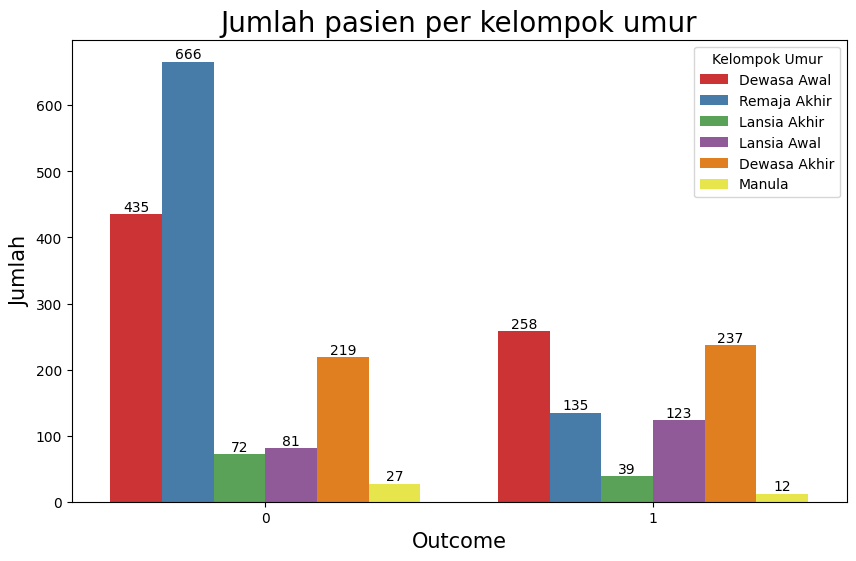

In [15]:
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', hue='Age_grup', data=data, palette='Set1')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien per kelompok umur', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15) 
plt.legend(loc='upper right', title='Kelompok Umur')  
plt.show() 

In [16]:
data[['Outcome', 'Age_grup']].value_counts()

Outcome  Age_grup    
0        Remaja Akhir    666
         Dewasa Awal     435
1        Dewasa Awal     258
         Dewasa Akhir    237
0        Dewasa Akhir    219
1        Remaja Akhir    135
         Lansia Awal     123
0        Lansia Awal      81
         Lansia Akhir     72
1        Lansia Akhir     39
0        Manula           27
1        Manula           12
Name: count, dtype: int64

Banyak pasien yang terkena diabetes adalah yang berumur 26-35 tahun atau dewasa awal dengan jumlah 86 orang lalu diikutu dengan dewasa akhir yaitu 46-55 tahun dengan jumlah 79 orang dan yang paling sedikit adalah manula dengan jumlah 4 orang.

In [17]:
BMI_grup = []
for i in data['BMI']:
    if i >= 0 and i <= 18.5:
        BMI_grup.append('Kurus')
    elif i >= 18.6 and i <= 22.9:
        BMI_grup.append('Normal')
    elif i >= 23 and i <= 24.9:
        BMI_grup.append('Gemuk')
    elif i >= 25 and i <= 29.9:
        BMI_grup.append('Obesitas')
    else:
        BMI_grup.append('Obesitas II')            

In [18]:
data['BMI_grup'] = BMI_grup
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_grup,BMI_grup
0,6,148,72,35,0,33.6,0.627,50,1,Lansia Awal,Obesitas II
1,1,85,66,29,0,26.6,0.351,31,0,Dewasa Awal,Obesitas
2,8,183,64,0,0,23.3,0.672,32,1,Dewasa Awal,Gemuk
3,1,89,66,23,94,28.1,0.167,21,0,Remaja Akhir,Obesitas
4,0,137,40,35,168,43.1,2.288,33,1,Dewasa Awal,Obesitas II
...,...,...,...,...,...,...,...,...,...,...,...
2299,10,101,76,48,180,32.9,0.171,63,0,Lansia Akhir,Obesitas II
2300,2,122,70,27,0,36.8,0.340,27,0,Dewasa Awal,Obesitas II
2301,5,121,72,23,112,26.2,0.245,30,0,Dewasa Awal,Obesitas
2302,1,126,60,0,0,30.1,0.349,47,1,Lansia Awal,Obesitas II


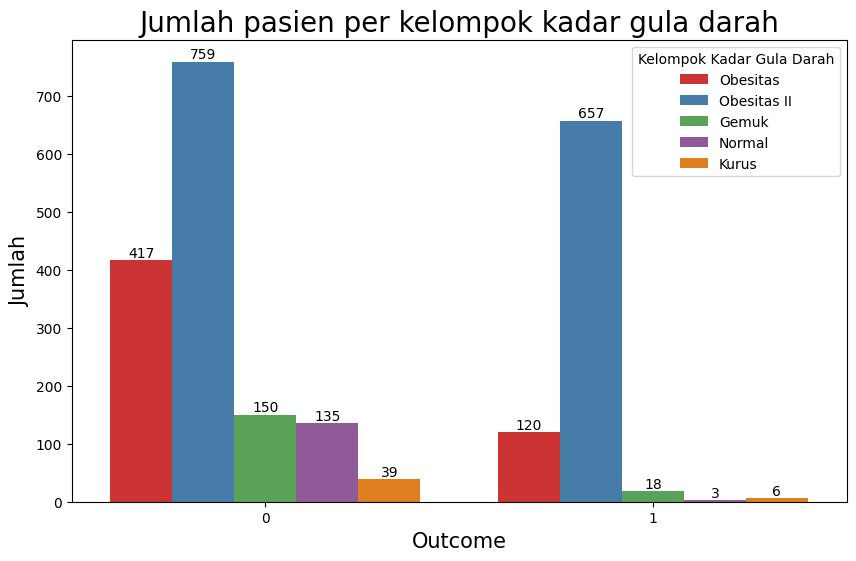

In [19]:
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', hue='BMI_grup', data=data, palette='Set1')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien per kelompok kadar gula darah', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15)
plt.legend(loc='upper right', title='Kelompok Kadar Gula Darah')
plt.show()    

In [20]:
data[['Outcome', 'BMI_grup']].value_counts()

Outcome  BMI_grup   
0        Obesitas II    759
1        Obesitas II    657
0        Obesitas       417
         Gemuk          150
         Normal         135
1        Obesitas       120
0        Kurus           39
1        Gemuk           18
         Kurus            6
         Normal           3
Name: count, dtype: int64

Berdasarkan kelompok BMI yang paling banyak terkena diabetes adalah yang memiliki BMI lebih dari 30 (Obesitasa II) dengan jumlah 219 orang lalu diikuti dengan BMI 25 - 29.9 (Obesitas) dengan jumlah 40 orang.

In [21]:
data = data.drop(columns=['Age_grup', 'BMI_grup'])
print(data.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [22]:
print(data.columns)
print(data.isnull().sum())
data = data.drop_duplicates()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


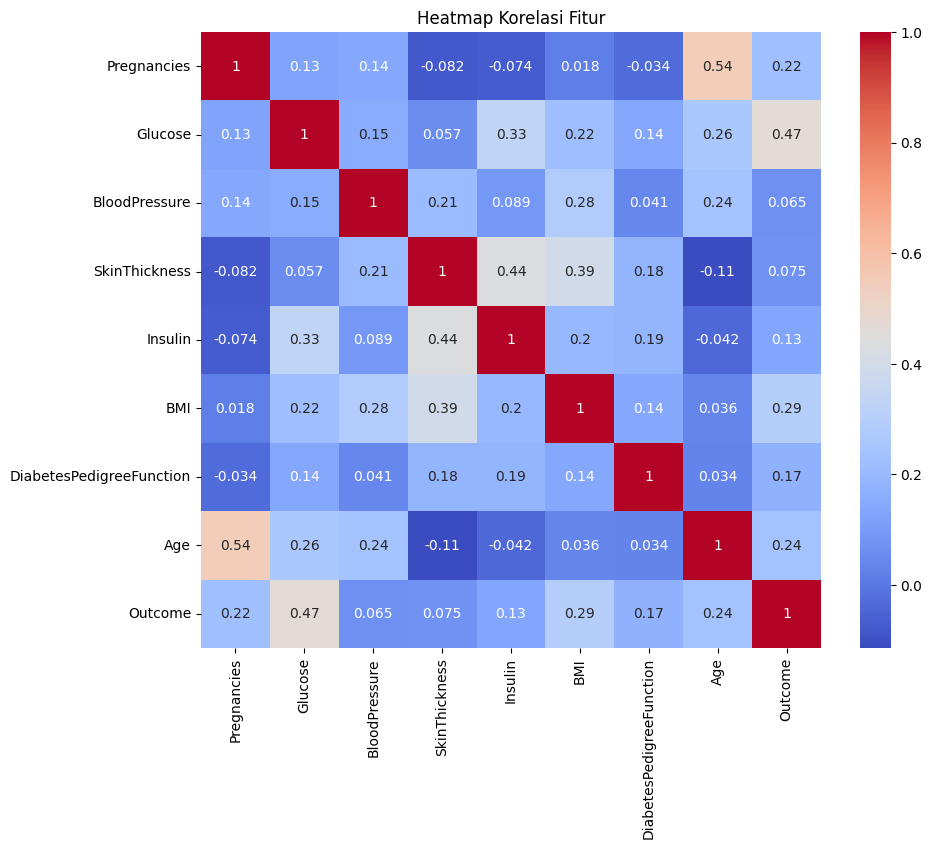

In [23]:
corr = data.corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()

### 4. Data Cleaning

4.1 Tangani Missing Values

In [24]:
# Kolom yang tidak boleh punya nilai 0
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Ganti nilai 0 menjadi NaN
data[invalid_zero_cols] = data[invalid_zero_cols].replace(0, np.nan)

# Cek jumlah missing values
print("Missing values setelah diganti:")
print(data.isnull().sum())

Missing values setelah diganti:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


4.2 Hapus Kolom dengan Banyak Missing dan Korelasi Rendah

In [25]:
data.drop(['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction'], axis=1, inplace=True)

Kolom Insulin dan SkinThickness memiliki lebih dari 30-40% nilai kosong (0 sebelumnya), serta korelasi rendah dengan Outcome. Maka, kita hapus, Kolom DiabetesPedigreeFunction juga memiliki korelasi rendah dengan Outcome dan sulit diukur langsung secara medis,

In [26]:
print(data.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age', 'Outcome'], dtype='object')


4.3 Imputasi Missing Values untuk Kolom Penting

In [27]:
from sklearn.impute import KNNImputer
# Pisahkan fitur dan target
X_temp = data.drop(columns='Outcome')
y_temp = data['Outcome']

# Lakukan imputasi
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X_temp)

# Buat ulang DataFrame
columns = X_temp.columns
data_imputed = pd.DataFrame(X_imputed, columns=columns)
data_imputed['Outcome'] = y_temp

# Simpan hasil imputasi ke variabel akhir (optional)
data = data_imputed

# Cek missing
print("Cek missing setelah imputasi:")
print(data.isnull().sum())

Cek missing setelah imputasi:
Pregnancies      0
Glucose          0
BloodPressure    0
BMI              0
Age              0
Outcome          0
dtype: int64


4.4 Tangani Duplikasi

In [28]:
print("Jumlah data sebelum drop duplikat:", data.shape[0])
data.drop_duplicates(inplace=True)
print("Jumlah data setelah drop duplikat:", data.shape[0])

Jumlah data sebelum drop duplikat: 768
Jumlah data setelah drop duplikat: 768


4.5 Feature Enginering

In [30]:
# Buat fitur baru
data['Glucose_BMI'] = data['Glucose'] * data['BMI']
data['Age_BMI'] = data['Age'] * data['BMI']
data['BP_Age'] = data['BloodPressure'] / (data['Age'] + 1)

# Buat kategori BMI  
data['BMI_Category'] = pd.cut(data['BMI'], 
                               bins=[0, 18.5, 25, 30, 100], 
                               labels=[0, 1, 2, 3]).astype(int)


4.5 Tangani Outlier 

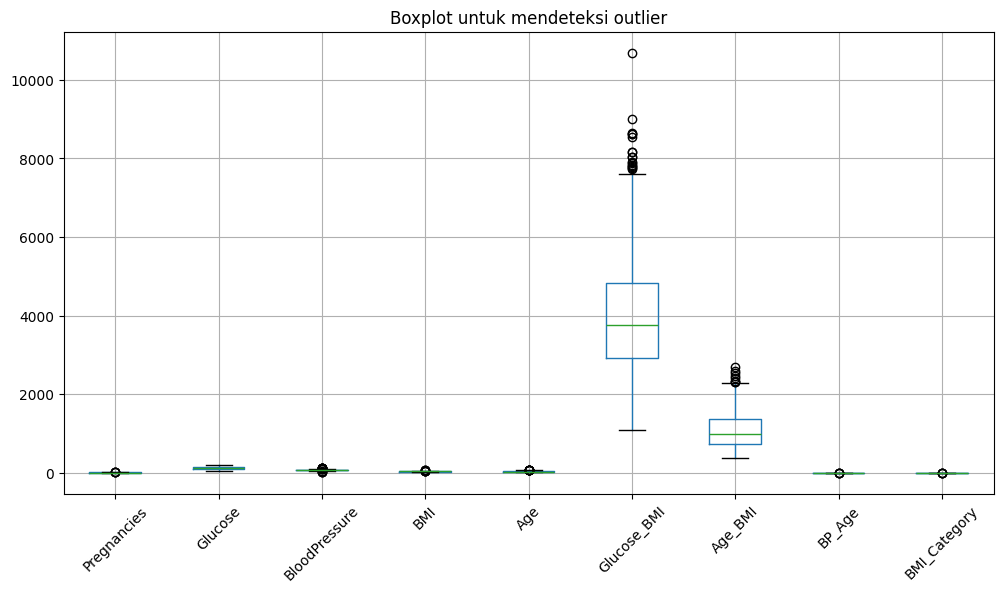

In [31]:
# Visualisasi boxplot semua fitur numerik
plt.figure(figsize=(12,6))
data.drop('Outcome', axis=1).boxplot()
plt.title("Boxplot untuk mendeteksi outlier")
plt.xticks(rotation=45)
plt.show()

In [32]:
def winsorize_outliers(df, cols, lower_percentile=0.05, upper_percentile=0.95):
    for col in cols:
        lower_bound = df[col].quantile(lower_percentile)
        upper_bound = df[col].quantile(upper_percentile)
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

numerical_cols = [col for col in data.select_dtypes(include=['float64', 'int64']).columns 
                  if col not in ['Outcome', 'BMI_Category']]
data = winsorize_outliers(data, numerical_cols)
print("Shape data setelah winsorizing:", data.shape)

Shape data setelah winsorizing: (768, 10)


# 5. Data Transformation

5.1 Persiapan Data

In [33]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']
X = data[features]
y = data['Outcome']

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

5.2 Feature Scaling

In [34]:
# 3. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [36]:
data.to_csv("diabetes_prepared.csv", index=False)

# Modeling

In [37]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "SVM": SVC(kernel='linear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB()
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

print("Hasil Evaluasi Model:")
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy:.4f}")

best_model_name = max(results, key=results.get)
print(f"\nModel Terbaik Berdasarkan Akurasi: {best_model_name} (Accuracy = {results[best_model_name]:.4f})")

Hasil Evaluasi Model:
Logistic Regression: Accuracy = 0.7143
SVM: Accuracy = 0.7078
Decision Tree: Accuracy = 0.6883
Random Forest: Accuracy = 0.7468
Gradient Boosting: Accuracy = 0.7468
AdaBoost: Accuracy = 0.7727
K-Nearest Neighbors: Accuracy = 0.7597
Gaussian Naive Bayes: Accuracy = 0.7143

Model Terbaik Berdasarkan Akurasi: AdaBoost (Accuracy = 0.7727)


Hyperparameter Tuning Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'class_weight': None, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Score: 0.7769292283086766


Final Model Random Forest

In [39]:
best_rf = grid_search.best_estimator_

# Fit model dengan data training
best_rf.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

# Evaluation

In [40]:
X_train_pred = best_rf.predict(X_train_scaled)
training_accuracy = accuracy_score(y_train, X_train_pred)
print("Akurasi data training adalah = ", training_accuracy)

Akurasi data training adalah =  0.8387622149837134


In [41]:
X_test_pred = best_rf.predict(X_test_scaled)
testing_accuracy = accuracy_score(y_test, X_test_pred)
print("Akurasi data testing adalah = ", testing_accuracy)

print("\nClassification Report pada data testing:")
print(classification_report(y_test, X_test_pred))

Akurasi data testing adalah =  0.7597402597402597

Classification Report pada data testing:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       100
           1       0.69      0.57      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.76      0.75       154



In [42]:
# Simpan model dan scaler
joblib.dump(best_rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [44]:
# Load model dan scaler
classifier = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

# Data input pasien
input_data = (6, 148, 72, 33.6, 50)
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']

# Buat DataFrame agar sesuai dengan fitur saat scaler dilatih
input_df = pd.DataFrame([input_data], columns=feature_names)

# Scaling dan prediksi
input_scaled = scaler.transform(input_df)
prediction = classifier.predict(input_scaled)

print(f"Prediksi: {prediction[0]}")

if prediction[0] == 0:
    print('✅ Pasien tidak terkena diabetes')
else:
    print('⚠️ Pasien terkena diabetes')

Prediksi: 1
⚠️ Pasien terkena diabetes


In [45]:
# Data input pasien
input_data = (1, 85, 66, 26.6, 30)  
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']

# Buat DataFrame agar sesuai dengan fitur saat scaler dilatih
input_df = pd.DataFrame([input_data], columns=feature_names)

# Scaling dan prediksi
input_scaled = scaler.transform(input_df)
prediction = classifier.predict(input_scaled)

# Output prediksi
print(f"Prediksi: {prediction[0]}")

if prediction[0] == 0:
    print('✅ Pasien tidak terkena diabetes')
else:
    print('⚠️ Pasien terkena diabetes')

Prediksi: 0
✅ Pasien tidak terkena diabetes
